<a href="https://colab.research.google.com/github/AhmedNasser1601/Flower-Classification/blob/Main/Flower-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install torch-lr-finder

In [71]:
import os
import tarfile
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch_lr_finder import LRFinder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms, datasets
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [42]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Projects/Flower Classification/'
image_folder_path = dataset_path + 'jpg'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
if not os.path.exists(image_folder_path):
  with tarfile.open(dataset_path + '102flowers.tgz', 'r:gz') as tar:
    members = tar.getmembers()
    for member in tqdm(members, desc="Extracting", unit="file"):
      tar.extract(member, path=dataset_path)

print(f"Total images found: {len(os.listdir(image_folder_path))}")

Total images found: 8189


In [44]:
labels = scipy.io.loadmat(dataset_path + 'imagelabels.mat')['labels'][0]
print(f"Labels: {len(labels)}")

Labels: 8189


In [45]:
class FlowerDataset(Dataset):
  def __init__(self, image_ids, labels, root_path, transform=None):
    self.image_ids = image_ids
    self.labels = labels
    self.root_path = root_path
    self.transform = transform

    self.image_paths = [os.path.join(root_path, f) for f in os.listdir(root_path)]

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    img_path = self.image_paths[self.image_ids[idx]]
    image = Image.open(img_path).convert("RGB")
    label = self.labels[self.image_ids[idx]] - 1

    if self.transform:
      image = self.transform(image)

    return image, label

In [46]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [47]:
'''
data_splits = scipy.io.loadmat(dataset_path + 'setid.mat')

train_ids = data_splits['trnid'][0]
val_ids = data_splits['valid'][0]
test_ids = data_splits['tstid'][0]

print(f"Train: {len(train_ids)}\tValid: {len(val_ids)}\tTest: {len(test_ids)}")
'''

total_samples = len(labels)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

train_ids, val_ids, test_ids = random_split(range(total_samples), [train_size, val_size, test_size])
print(f"Train: {len(train_ids)}\tValid: {len(val_ids)}\tTest: {len(test_ids)}")

Train: 4913	Valid: 1637	Test: 1639


In [48]:
train_dataset = FlowerDataset(train_ids, labels, image_folder_path, train_transform)
val_dataset = FlowerDataset(val_ids, labels, image_folder_path, val_transform)
test_dataset = FlowerDataset(test_ids, labels, image_folder_path, val_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [58]:
model = models.vgg19(pretrained=True)

In [59]:
for param in model.features.parameters():
  param.requires_grad = False

model.classifier[-1] = nn.Linear(in_features=4096, out_features=102)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-04


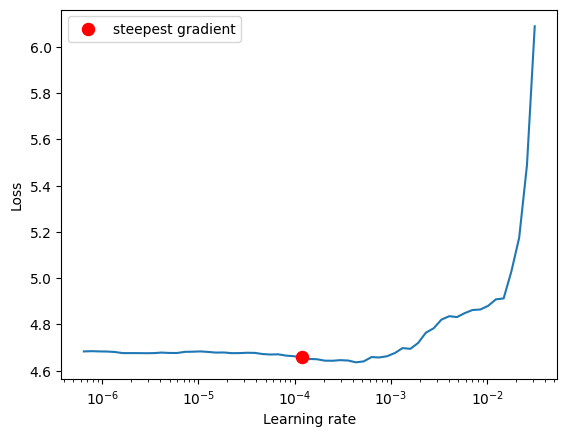

In [62]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader)
lr_finder.plot()
lr_finder.reset()

In [63]:
lr_finder._set_learning_rate(1.18E-04)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.000118
    maximize: False
    weight_decay: 0
)

In [64]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
  # Training
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for inputs, labels in tqdm(train_loader, desc=f"\t<Train>", dynamic_ncols=True):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted_train = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted_train == labels).sum().item()

  train_accuracy = correct_train / total_train
  train_losses.append(running_loss / len(train_loader))
  train_accuracies.append(train_accuracy)

  # Validation
  model.eval()
  correct_val = 0
  total_val = 0
  val_loss = 0.0

  with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc=f"\t<Valid>", dynamic_ncols=True):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      val_loss += criterion(outputs, labels).item()

      _, predicted_val = torch.max(outputs.data, 1)
      total_val += labels.size(0)
      correct_val += (predicted_val == labels).sum().item()

  val_accuracy = correct_val / total_val
  val_losses.append(val_loss / len(val_loader))
  val_accuracies.append(val_accuracy)

  print(f"[Epoch {epoch+1}/{num_epochs}] => Train_Loss: {train_losses[-1]:.4f} | Train_Acc: {train_accuracy*100:.2f}% | Valid_Loss: {val_losses[-1]:.4f} | Valid_Acc: {val_accuracy*100:.2f}%")

	<Valid>: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]


[Epoch 1/10] => Train_Loss: 4.6118 | Train_Acc: 2.42% | Valid_Loss: 4.5516 | Valid_Acc: 2.93%


	<Valid>: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


[Epoch 2/10] => Train_Loss: 4.5354 | Train_Acc: 2.73% | Valid_Loss: 4.5360 | Valid_Acc: 1.89%


	<Valid>: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


[Epoch 3/10] => Train_Loss: 4.5158 | Train_Acc: 2.71% | Valid_Loss: 4.5400 | Valid_Acc: 2.38%


	<Valid>: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


[Epoch 4/10] => Train_Loss: 4.5016 | Train_Acc: 2.97% | Valid_Loss: 4.5535 | Valid_Acc: 2.20%


	<Valid>: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


[Epoch 5/10] => Train_Loss: 4.4845 | Train_Acc: 3.77% | Valid_Loss: 4.5553 | Valid_Acc: 2.50%


	<Valid>: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]


[Epoch 6/10] => Train_Loss: 4.4618 | Train_Acc: 3.99% | Valid_Loss: 4.5600 | Valid_Acc: 2.20%


	<Valid>: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


[Epoch 7/10] => Train_Loss: 4.4482 | Train_Acc: 3.58% | Valid_Loss: 4.5618 | Valid_Acc: 2.50%


	<Valid>: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


[Epoch 8/10] => Train_Loss: 4.4413 | Train_Acc: 3.64% | Valid_Loss: 4.5722 | Valid_Acc: 2.63%


	<Valid>: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


[Epoch 9/10] => Train_Loss: 4.4139 | Train_Acc: 4.46% | Valid_Loss: 4.6034 | Valid_Acc: 1.89%


	<Valid>: 100%|██████████| 26/26 [00:19<00:00,  1.32it/s]

[Epoch 10/10] => Train_Loss: 4.4094 | Train_Acc: 4.50% | Valid_Loss: 4.6034 | Valid_Acc: 1.89%


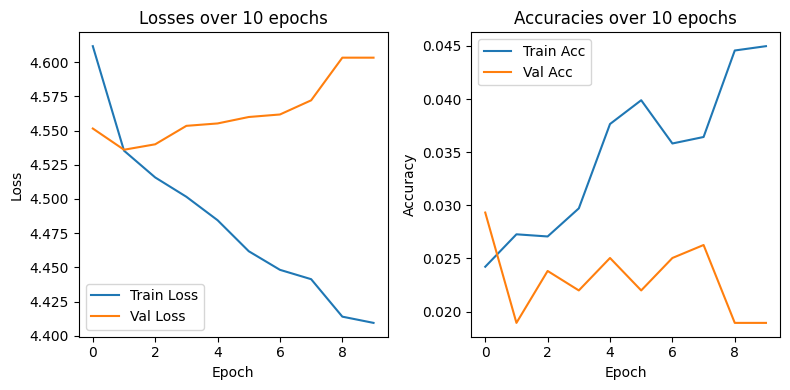

In [65]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over ' + str(num_epochs) + ' epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracies over ' + str(num_epochs) + ' epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [98]:
# Testing
model.eval()
correct_test = 0
total_test = 0

predicted_labels = []
predicted_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
  for inputs, labels in tqdm(test_loader, desc=f"\t<Test>", dynamic_ncols=True):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print(f"\nTesting Accuracy: {(correct_test / total_test) * 100:.2f}%")

	<Test>: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s]


Testing Accuracy: 2.56%


In [99]:
# Predictions
for i in range(25):
  print(f"[{i}] => Actual: {labels[i].item()}\tPredicted: {predicted_labels[i]}\t{(labels[i].item()) == (predicted_labels[i])}")

[0] => Actual: 76	Predicted: 72	False
[1] => Actual: 72	Predicted: 80	False
[2] => Actual: 91	Predicted: 29	False
[3] => Actual: 52	Predicted: 77	False
[4] => Actual: 59	Predicted: 64	False
[5] => Actual: 67	Predicted: 76	False
[6] => Actual: 59	Predicted: 77	False
[7] => Actual: 80	Predicted: 50	False
[8] => Actual: 70	Predicted: 72	False
[9] => Actual: 83	Predicted: 50	False
[10] => Actual: 28	Predicted: 77	False
[11] => Actual: 88	Predicted: 80	False
[12] => Actual: 54	Predicted: 45	False
[13] => Actual: 38	Predicted: 76	False
[14] => Actual: 42	Predicted: 80	False
[15] => Actual: 81	Predicted: 76	False
[16] => Actual: 85	Predicted: 76	False
[17] => Actual: 57	Predicted: 64	False
[18] => Actual: 17	Predicted: 36	False
[19] => Actual: 5	Predicted: 45	False
[20] => Actual: 14	Predicted: 76	False
[21] => Actual: 74	Predicted: 45	False
[22] => Actual: 54	Predicted: 50	False
[23] => Actual: 55	Predicted: 64	False
[24] => Actual: 27	Predicted: 80	False


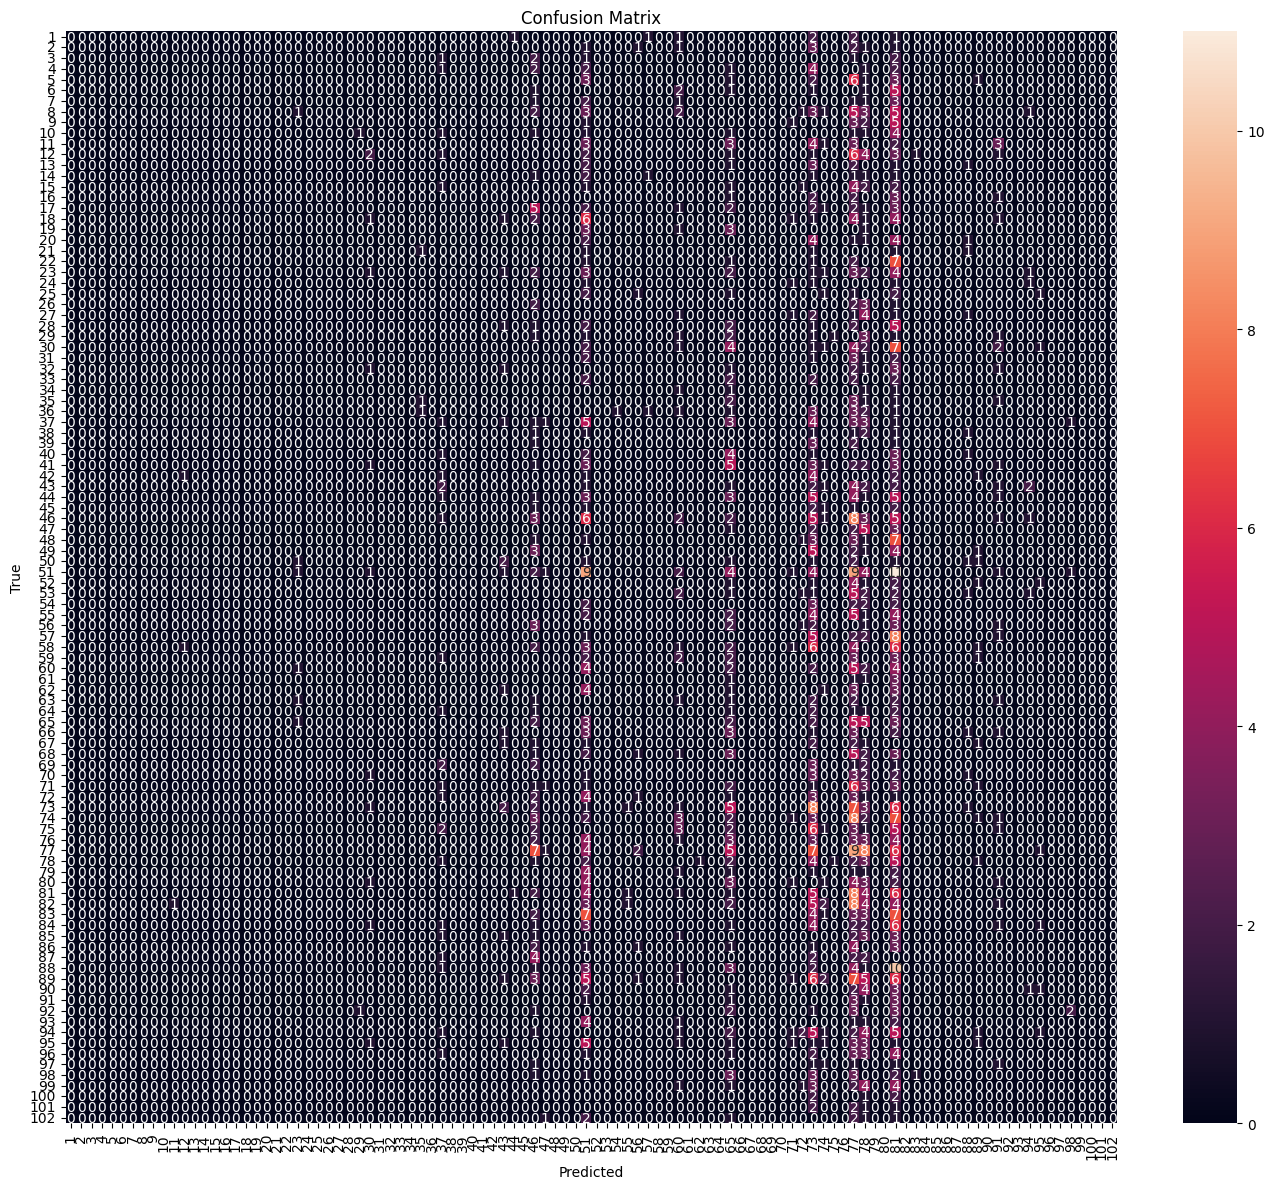

In [100]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = [str(i) for i in range(1, 103)]

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [101]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        19
          12       0.00      0.00      0.00        22
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00         9
          17       0.00      0.00      0.00        19
          18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
